In [2]:
from torchvision import transforms
from enum import Enum, auto
from math import floor, ceil
from torch.nn import functional as F
from typing import TYPE_CHECKING
import torch
import numpy as np
import monai
from monai.transforms import Compose, CenterSpatialCrop, Rand3DElastic, RandAffine, RandGaussianNoise, NormalizeIntensity
import matplotlib.pyplot as plt
import nibabel as nib
from BIDS.core.np_utils import np_dice
from BIDS import NII
from BIDS.core.np_utils import np_map_labels, Label_Map


/home/martina/.conda/envs/dae_cond/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

rand_affine = RandAffine(
    spatial_size=(144, 96, 144),
    translate_range=(5, 5, 5),
    rotate_range=(np.pi / 18, np.pi / 18, np.pi / 9),  # 20 degrees in radians
    scale_range=(0.8, 1.2),  # 20% scaling
    padding_mode="zeros",
)
rand_affine.set_random_state(seed=123)


2
('P', 'I', 'R')
(1, 144, 96, 144)
torch.Size([1, 144, 96, 144])
torch.Size([1, 144, 96, 144])
{41: 0.2, 42: 0.3, 43: 0.4, 44: 0.5, 45: 0.6, 46: 0.7, 47: 0.8, 48: 0.9, 49: 1.0}
{41: 0.2, 42: 0.3, 43: 0.4, 44: 0.5, 45: 0.6, 46: 0.7, 47: 0.8, 48: 0.9, 49: 1.0}
img_trans [0.  0.3 1. ]


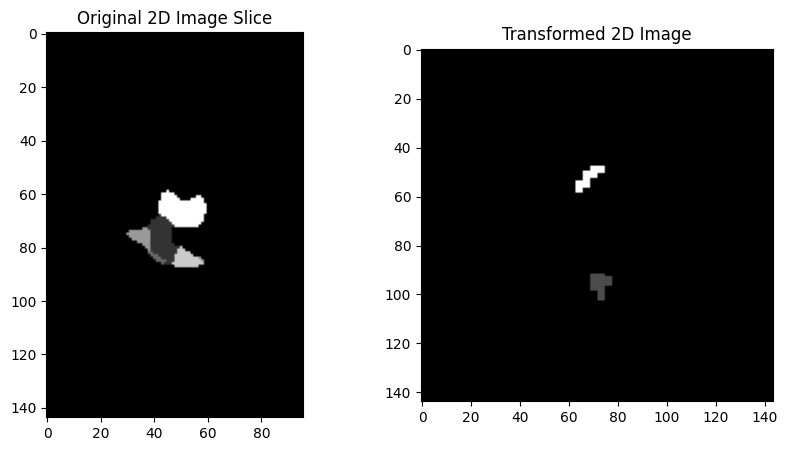

img_trans_not mapped [0.  0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
img_trans_ mapped [ 0. 41. 42. 43. 44. 45. 46. 47. 48. 49.]
img_trans_squeezed and mapped [ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
img [ 0. 41. 42. 43. 44. 45. 46. 47. 48. 49.]
[ ] 'set_array' with different dtype: from uint8 to float64
[*] Save Transformed_verse16_012_mapped.nii.gz as uint8


In [4]:
def np_flip(x, dim):
    print(x.ndim)
    dim = x.ndim + dim if dim < 0 else dim
    print(dim)
    return x[
        tuple(
            slice(None, None) if i != dim else np.arange(x.shape[i] - 1, -1, -1)
            for i in range(x.ndim)
        )
    ]

def np_rhsubf(image: np.ndarray, dim: int, tmp=60):
    assert (
        np.max(image) >= 1
    ), f"RHF without a image1 doesnt work! {np.min(image)}, {np.max(image)}"
    image_f = np.flip(image, dim)  # np_flip(image, dim=dim)
    for pair in [(43, 44), (45, 46), (47, 48)]:  # costalis, superior, inferior
        image_f[image_f == pair[0]] = tmp
        image_f[image_f == pair[1]] = pair[0]
        image_f[image_f == tmp] = pair[1]
    return image_f

def segmentation_map_to_model_map(y):
    y = y.astype(float)
    labelmap = {i: round(0.1*(i - 39), ndigits=2) for i in range(41, 50)} #  labelmap = {i: round((i - 40)/9, ndigits=2) for i in range(41, 50)}
    print(labelmap)
    return np_map_labels(y, labelmap)

def model_map_to_segmentation_map(x):
    x *= 10
    x = np.round(x)# round nearest int
    #print("rounded*10",x)
    x = x + 39
    x = np_map_labels(x, {39: 0})
    return x
# Load the NIfTI image
sample_path = "/media/DATA/martina_ma/cutout/verse016/verse016_012_subreg_cropped.nii.gz"             #"/media/DATA/martina_ma/datasets/verse011/verse011_008_subreg_cropped.nii.gz"#verse013_024_subreg_cropped.nii.gz"
img_nifti = NII.load(sample_path, True)
print(img_nifti.get_axis('R'))
print(img_nifti.orientation)
# Extract the image data as a NumPy array
img_data = img_nifti.get_seg_array() 
img_data = np_map_labels(arr=img_data,label_map={50: 49})
img_data_expanded = np.expand_dims(img_data, axis=0)#.unsqueeze(0)
print(img_data_expanded.shape)
img_data_transformed = rand_affine(img_data_expanded)#np_rhsubf(img_data,2)
print(img_data_transformed.shape)
#img_data_transformed = np.squeeze(img_data_transformed, axis=0)
print(img_data_transformed.shape)

img_data = segmentation_map_to_model_map(img_data)
img_data_transformed = segmentation_map_to_model_map(img_data_transformed)

img_slice = img_data[:, :, 60]
img_slice_flipped = img_data_transformed[:, :, 60]

print("img_trans",np.unique(img_slice_flipped))

#Display the image using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_slice, cmap="gray")
ax[0].set_title("Original 2D Image Slice")
ax[1].imshow(img_slice_flipped[0], cmap="gray") #img_slice_flipped[0]
ax[1].set_title("Transformed 2D Image")
#class monai.transforms.RandSpatialCrop
plt.show()
print("img_trans_not mapped",np.unique(img_data_transformed))
img_data_flipped= model_map_to_segmentation_map(img_data_transformed)
print("img_trans_ mapped",np.unique(img_data_flipped))
img_data_transformed = np.squeeze(img_data_transformed, axis=0)
print("img_trans_squeezed and mapped",np.unique(img_data_transformed))
img_data_transformed = img_data_transformed +39
img_data_transformed = np_map_labels(img_data_transformed, {39: 0})
print("img",np.unique(img_data_transformed))
img_nifti.set_array_(img_data_transformed).save("Transformed_verse16_012_mapped.nii.gz")


In [5]:
import os
import random
import pandas as pd

data_dir = "/media/DATA/martina_ma/cutout"
csv_file_path = "/media/DATA/martina_ma/cutout/train_3D_95_all_dataset.csv"  # Replace with the desired output CSV file path


# List of NIfTI files to exclude
files_to_exclude = ["verse814_019_subreg_cropped.nii.gz", "verse814_018_subreg_cropped.nii.gz","verse814_020_subreg_cropped.nii.gz",
                    "verse642_019_subreg_cropped.nii.gz", "verse642_018_subreg_cropped.nii.gz","verse642_020_subreg_cropped.nii.gz",
                    "verse636_019_subreg_cropped.nii.gz", "verse636_018_subreg_cropped.nii.gz","verse636_020_subreg_cropped.nii.gz",
                    "verse626_019_subreg_cropped.nii.gz", "verse626_018_subreg_cropped.nii.gz","verse626_020_subreg_cropped.nii.gz",
                    "verse606_019_subreg_cropped.nii.gz", "verse606_018_subreg_cropped.nii.gz","verse606_020_subreg_cropped.nii.gz",
                    "verse581_019_subreg_cropped.nii.gz", "verse581_018_subreg_cropped.nii.gz","verse581_020_subreg_cropped.nii.gz",
                    "verse559_019_subreg_cropped.nii.gz", "verse559_018_subreg_cropped.nii.gz","verse559_020_subreg_cropped.nii.gz",
                    "verse544_019_subreg_cropped.nii.gz", "verse544_018_subreg_cropped.nii.gz","verse544_020_subreg_cropped.nii.gz",
                    "verse535_025_new_subreg_cropped.nii.gz", "verse599_025_new_subreg_cropped.nii.gz","verse555_025_new_subreg_cropped.nii.gz",
"verse591_024_new_subreg_cropped.nii.gz", "verse617_024_new_subreg_cropped.nii.gz","verse526_025_new_subreg_cropped.nii.gz",
"verse534_025_new_subreg_cropped.nii.gz", "ctfu00974_012_subreg_cropped.nii.gz",
"verse024_025_new_subreg_cropped.nii.gz",
"verse584_024_new_subreg_cropped.nii.gz",
"verse609_025_new_subreg_cropped.nii.gz",
"fxclass0339_009_subreg_cropped.nii.gz",
"ctfu00155_021_subreg_cropped.nii.gz",
"fxclass0056_019_subreg_cropped.nii.gz",
"verse587_025_new_subreg_cropped.nii.gz",
"verse581_025_new_subreg_cropped.nii.gz",
"verse088_025_new_subreg_cropped.nii.gz",
"verse626_025_new_subreg_cropped.nii.gz",
"verse606_025_new_subreg_cropped.nii.gz",
"fxclass0290_014_subreg_cropped.nii.gz",
"fxclass0352_009_subreg_cropped.nii.gz",
"verse616_025_new_subreg_cropped.nii.gz",
"verse590_025_new_subreg_cropped.nii.gz",
"ctfu00074_014_subreg_cropped.nii.gz",
"verse510_025_new_subreg_cropped.nii.gz",
"verse592_025_new_subreg_cropped.nii.gz",
"verse573_024_new_subreg_cropped.nii.gz",
"fxclass0178_012_subreg_cropped.nii.gz"]

# List of subejcts for test split
selected_folders =["/media/DATA/martina_ma/cutout/verse009",
"/media/DATA/martina_ma/cutout/verse073",
"/media/DATA/martina_ma/cutout/verse269",
"/media/DATA/martina_ma/cutout/verse750",
"/media/DATA/martina_ma/cutout/verse712",
"/media/DATA/martina_ma/cutout/verse594",
"/media/DATA/martina_ma/cutout/verse236",
"/media/DATA/martina_ma/cutout/verse757",
"/media/DATA/martina_ma/cutout/verse650",
"/media/DATA/martina_ma/cutout/verse068",
"/media/DATA/martina_ma/cutout/verse080",
"/media/DATA/martina_ma/cutout/verse759",
"/media/DATA/martina_ma/cutout/verse511",
"/media/DATA/martina_ma/cutout/verse260",
"/media/DATA/martina_ma/cutout/verse081",
"/media/DATA/martina_ma/cutout/verse514",
"/media/DATA/martina_ma/cutout/fxclass0326",
"/media/DATA/martina_ma/cutout/fxclass0037",
"/media/DATA/martina_ma/cutout/fxclass0271",
"/media/DATA/martina_ma/cutout/fxclass0309",
"/media/DATA/martina_ma/cutout/fxclass0019",
"/media/DATA/martina_ma/cutout/fxclass0334",
"/media/DATA/martina_ma/cutout/fxclass0120",
"/media/DATA/martina_ma/cutout/fxclass0384",
"/media/DATA/martina_ma/cutout/fxclass0205",
"/media/DATA/martina_ma/cutout/fxclass0159",
"/media/DATA/martina_ma/cutout/fxclass0321",
"/media/DATA/martina_ma/cutout/fxclass0218",
"/media/DATA/martina_ma/cutout/fxclass0185",
"/media/DATA/martina_ma/cutout/fxclass0314",
"/media/DATA/martina_ma/cutout/fxclass0059",
"/media/DATA/martina_ma/cutout/fxclass0103",
"/media/DATA/martina_ma/cutout/fxclass0018",
"/media/DATA/martina_ma/cutout/fxclass0277",
"/media/DATA/martina_ma/cutout/fxclass0110",
"/media/DATA/martina_ma/cutout/tri018",
"/media/DATA/martina_ma/cutout/ctfu00006",
"/media/DATA/martina_ma/cutout/ctfu00492",
"/media/DATA/martina_ma/cutout/ctfu00289",
"/media/DATA/martina_ma/cutout/ctfu00521",
"/media/DATA/martina_ma/cutout/verse553" #broken segmentation
]

#/media/DATA/martina_ma/data/dataset-rsna/derivatives_spine_r/17481
#rsna: sub-3168_seg-subreg_msk.nii.gz
# Create a list to store the file paths
file_paths = []
# and ("verse" in root or "tri" in root or "rsna" in root or "fxclass" in root)#
# Traverse the directories
# for root, dirs, files in os.walk(data_dir):
#     if root not in selected_folders: #"verse" in root and 
#         for file in files:
#             if file.endswith(".nii.gz") and ("new" in file and "verse" in root) and file not in files_to_exclude: 
#                 file_paths.append(os.path.join(root, file))
#make train validation dataset
for root, dirs, files in os.walk(data_dir):
    if root not in selected_folders:
        for file in files:
            if file.endswith(".nii.gz") and file not in files_to_exclude:
                if "verse" in root and "new" in file:
                    file_paths.append(os.path.join(root, file))
                elif "verse" not in root:
                    file_paths.append(os.path.join(root, file))

file_paths_test = []
for root, dirs, files in os.walk(data_dir):
    if root in selected_folders and root != "/media/DATA/martina_ma/cutout/verse553":
        for file in files:
            if file.endswith(".nii.gz") and file not in files_to_exclude:
                if "verse" in root and "new" in file:
                    file_paths_test.append(os.path.join(root, file))
                elif "verse" not in root:
                    file_paths_test.append(os.path.join(root, file))


In [4]:
random.shuffle(file_paths_test)
csv_file_path_test = "/media/DATA/martina_ma/cutout/test_3D_95_all_dataset.csv"
splits = ["test"] * len(file_paths_test)
df = pd.DataFrame({"file_path": file_paths_test, "Split": splits})
df.to_csv(csv_file_path_test, index=False)  # Append without writing header

print(f"CSV file created at: {csv_file_path_test}")


CSV file created at: /media/DATA/martina_ma/cutout/test_3D_95_all_dataset.csv


In [6]:

# Shuffle the file paths randomly
random.shuffle(file_paths)
#file_paths = file_paths[:3720]

# Calculate the split index
split_index = int(0.8 * len(file_paths))
print(len(file_paths))
# Assign "train" to 80% of the data and "val" to the remaining 20%
splits = ["train"] * split_index + ["val"] * (len(file_paths) - split_index)
# 2979
#745
# Create a DataFrame
df = pd.DataFrame({"file_path": file_paths, "Split": splits})
# Add two rows with values "nii.gz" and "train" at the end
#additional_rows = pd.DataFrame({"file_path": ["/media/DATA/martina_ma/cutout/tri049/tri049_011_subreg_cropped.nii.gz", "/media/DATA/martina_ma/cutout/tri049/tri049_018_subreg_cropped.nii.gz"], "Split": ["train", "train"]})
#df = pd.concat([df, additional_rows], ignore_index=True)
# Save the DataFrame to a CSV file
#df.to_csv(csv_file_path, index=False)
df.to_csv(csv_file_path, index=False)  # Append without writing header

#additional_rows.to_csv(csv_file_path, index=False, mode='a', header=False)

print(f"CSV file created at: {csv_file_path}")


10618
CSV file created at: /media/DATA/martina_ma/cutout/train_3D_95_all_dataset.csv


In [10]:
import os

directory_path = "/media/DATA/martina_ma/cutout"

# Initialize a counter
folder_count = 0

# Iterate over the directories in the specified path
for root, dirs, files in os.walk(directory_path):
    # Check if the current directory is a "versexyz" folder
    if "ctfu" in root:
        # Check if any files in the folder contain the "new" keyword
        #if any("new" in file for file in files):
        folder_count += 1

# Print the count of "versexyz" folders containing files with "new" keyword
print(f"Number of 'versexyz' folders containing files with 'new': {folder_count}")


Number of 'versexyz' folders containing files with 'new': 73


In [11]:
print(0.05*73)

3.6500000000000004


In [12]:
import os
import random

directory_path = "/media/DATA/martina_ma/cutout"

# Initialize a list to store folder names
selected_folders = []

# Seed for reproducibility
random.seed(42)

# Iterate over the directories in the specified path
for root, dirs, files in os.walk(directory_path):
    # Check if the current directory is a "versexyz" folder
    if "ctfu" in root:
        # Check if any files in the folder contain the "new" keyword
        #if any("new" in file for file in files):
        selected_folders.append(root)

# Randomly select 16 folders
selected_folders = random.sample(selected_folders, min(4, len(selected_folders)))

# Print the list of selected "versexyz" folders
print("Selected folders:")
for folder in selected_folders:
    print(folder)


Selected folders:
/media/DATA/martina_ma/cutout/ctfu00006
/media/DATA/martina_ma/cutout/ctfu00492
/media/DATA/martina_ma/cutout/ctfu00289
/media/DATA/martina_ma/cutout/ctfu00521
